# Inhaltsverzeichnis
1. Bibliotheken importieren
1. Anomalien entfernen und Feature Engeneering
1. Merkmale auswählen
1. Regression
1. Modelle Bewerten
1. Vorhersage
1. Unabhängige Validierung
1. Evaluation GBT
1. Anleitung

*Um das Model zu testen, ändern Sie den Dateinamen im Code-Teil unter "Unabhängige Validierung".*

# 1. Bibliotheken importieren

In [24]:
# Data Science + Mathe Bibliotheken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

# Metriken
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

# Validierung
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Modelle
from sklearn import preprocessing 
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

# Warnungen 
import warnings

#define Mape
# https://www.statology.org/mape-python/
def mean_absolute_percentage_error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# 2. Anomalien entfernen und Feature Engeneering

In [2]:
housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)

warnings.filterwarnings('ignore')

# Bereinigung und Feature Engeneering

# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]

# Monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]

# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

# Alle Zustände werden von 1...X auf 0....X-1 geschoben
housing_data["HeizungsqualitaetN"] = [ x-1 for x in housing_data["Heizungsqualitaet"]]
housing_data["ZustandN"] = [ x-1 for x in housing_data["Zustandf"]]
housing_data["FassadeN"] = [ x-1 for x in housing_data["Zustand Fassade"]]
housing_data["KuecheN"] = [ x-1 for x in housing_data["Kuechenqualitaet"]]

# Klimaanlage Ja/Nein  -> 1/0
housing_data["Klimaanlage"] = [1 if x == "Y" else 0 for x in housing_data["Klimaanlage"]]

# Besonders Große Daten beim Preis + Wohnfläche in qm rausschmeißen
max_value = housing_data["Preis"].unique()[-1:][0]
housing_data[housing_data["Preis"] != max_value]

max_value = housing_data["Wohnflaeche in qm"].unique()[-1:][0]
housing_data[housing_data["Wohnflaeche in qm"] != max_value]

max_value = housing_data["Grundstueck in qm"].unique()[-2:][0]
housing_data[housing_data["Grundstueck in qm"] != max_value]


# NA in Garage Typ wird zu "Keine Garage"
housing_data["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data["Garage Typ"]]


print(housing_data.keys())

Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis',
       'Preisproqm', 'Monate', 'Zustandf', 'HeizungsqualitaetN', 'ZustandN',
       'FassadeN', 'KuecheN'],
      dtype='object')


# 3. Merkmale auswählen

In [3]:
# X und Y aus dem Datenset auslesen

# Zu testende Merkmale festlegen (X)
features = [ "Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN", "HeizungsqualitaetN", "FassadeN",
            "Klimaanlage", "Gebaut", "Garagenkapazitaet", "Raeume"]
# Preis (Y)
predict= "Preis"

X = {}
for feature in features:
    X[feature] = housing_data[feature]
X = pd.DataFrame(X)

Y = pd.DataFrame(housing_data[predict])

# 4. Regression

In [4]:
# K-fache Cross-Validierung
split = 10
Kfold = KFold(n_splits=split, random_state=90)
kfold = Kfold.split(X, Y)

model = {"data":[], "scores":{}, "models" : {}, "best" : {}, "types":["osl", "lasso", "ridge", "gbt", "rf", "sgd"]}
for mtype in model["types"]:
    model["scores"][mtype] = []
    model["models"][mtype] = []


for k, (train, test) in enumerate(kfold):
    model["models"]["osl"].append(linear_model.LinearRegression())
    model["models"]["lasso"].append(linear_model.Lasso())
    model["models"]["ridge"].append(linear_model.Ridge())
    model["models"]["gbt"].append(GradientBoostingRegressor(
        max_depth=4, n_estimators=100, learning_rate=0.15, loss="ls"))
    model["models"]["rf"].append(RandomForestRegressor(max_depth=10, n_estimators=10, criterion="mse"))
    model["models"]["sgd"].append(SGDRegressor())
    # Polynomielle Regression
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(X.iloc[train, :])
    poly.fit(X.iloc[train, :], Y.iloc[train])
    x_poly_test = poly.fit_transform(X.iloc[test, :])
    y_train = Y.iloc[train]
    y_test = Y.iloc[test]
    model["data"].append({"xpoly": x_poly, "x_train": X.iloc[train, :], "y_train": y_train, 
                          "x_poly_test": x_poly_test, "x_test": X.iloc[test, :], "y_test": y_test})
    for mtype in model["types"]:
        curr_model = model["models"][mtype][k]
        curr_model.fit(x_poly, y_train)
        score = r2_score(curr_model.predict(x_poly_test), y_test)
        model["scores"][mtype].append(score)
        
print("Done")

Done


# 5. Modelle Bewerten

r2_score von osl:	0.6945 +- 0.236 (0.8701 max)
r2_score von lasso:	0.8250 +- 0.063 (0.8898 max)
r2_score von ridge:	0.7320 +- 0.212 (0.8786 max)
r2_score von gbt:	0.8367 +- 0.031 (0.8841 max)
r2_score von rf:	0.8109 +- 0.036 (0.8943 max)


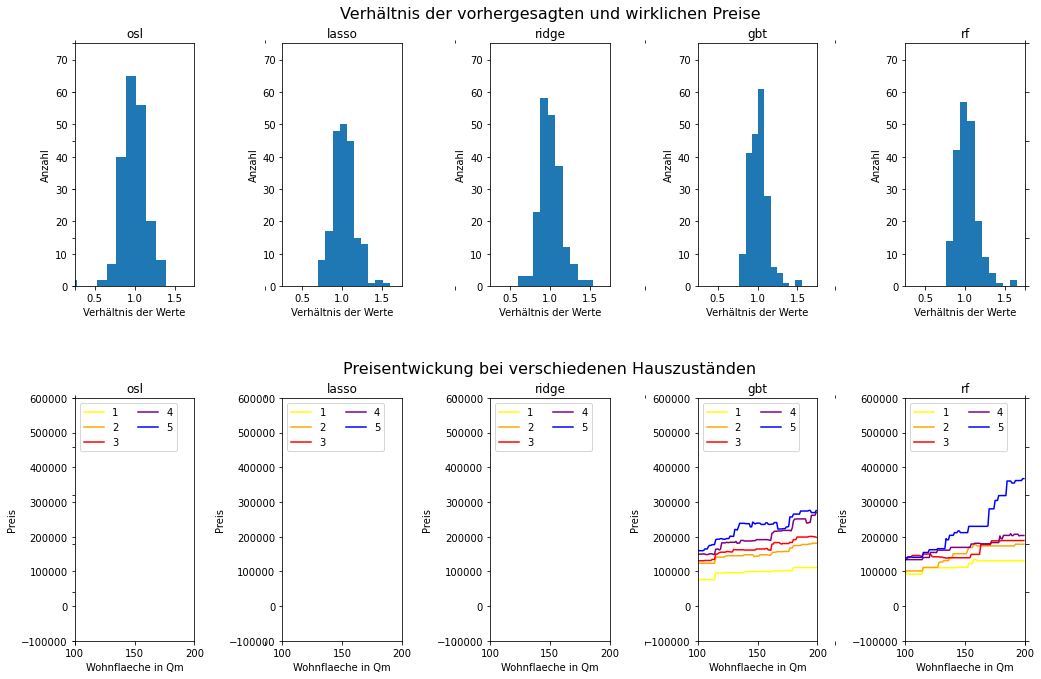

In [5]:
# Beste Modelle finden, r2_score ausgeben

# Nachdem sgd zu schlecht ist, wird es zur Evaluation entfernt!
if "sgd" in model["types"]:
    model["types"].remove("sgd")
    
for mtype in model["types"]:
    best = model["scores"][mtype].index(np.sort(model["scores"][mtype])[-1:][0])
    model["best"][mtype] = best    
    mean_score = np.mean(model["scores"][mtype])
    std_score = np.std(model["scores"][mtype])
    max_score = model["scores"][mtype][model["best"][mtype]]
    print("r2_score von %s:\t%.4f +- %.3f (%.4f max)" % (mtype, mean_score, std_score, max_score))


fig, big_axes = plt.subplots( figsize=(15, 10) , nrows=2, ncols=1)

big_axes[0].set_title("Verhältnis der vorhergesagten und wirklichen Preise",fontsize=16, pad=25)
big_axes[0].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[0]._frameon = False

big_axes[1].set_title("Preisentwickung bei verschiedenen Hauszuständen",fontsize=16,pad=25)
big_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
big_axes[1]._frameon = False



for i in range(len(model["types"])):
    mtype = model["types"][i]
    best_model = model["models"][mtype][model["best"][mtype]]
    x_test = model["data"][model["best"][mtype]]["x_test"]
    y_test = model["data"][model["best"][mtype]]["y_test"]
    pred_y = np.reshape(best_model.predict(poly.fit_transform(x_test)), (-1,1))
    
    # Abweichung in Prozent angeben
    ax = fig.add_subplot(2,len(model["types"]), i+1)
    plt.sca(ax)
    plt.hist(pred_y / y_test)
    plt.xlim(0.25,1.75)
    plt.ylim(0,75)
    plt.title(model["types"][i])
    plt.xlabel("Verhältnis der Werte")
    plt.ylabel("Anzahl")
    
    # Beispielvorhersage
    x = np.arange(100,200,1)
    y = []
    for c in range(5):
        y.append([])
        for v in x:
            #[ "Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN", "HeizungsqualitaetN", "FassadeN",
            # "Klimaanlage", "Gebaut", "Garagenkapazitaet", "Raeume"]
            y[c].append(best_model.predict(poly.fit_transform([[800 + 3*v, v, c , c, c, c, int(c/3), 2130, 2, 4]]))[0])
    
    ax = fig.add_subplot(2,len(model["types"]), i+1+len(model["types"]))
    plt.sca(ax)
    plt.xlim(100,200)
    #plt.ylim(-100000,600000)
    plt.plot(x, y[0], c="yellow", label="1")     
    plt.plot(x, y[1], c="orange", label="2")
    plt.plot(x, y[2], c="red", label="3")
    plt.plot(x, y[3], c="purple" ,label="4")
    plt.plot(x, y[4], c="blue" ,label="5")
    plt.legend(loc="upper left", ncol=2)
    plt.title(model["types"][i])
    plt.xlabel("Wohnflaeche in Qm")
    plt.ylabel("Preis")
    
plt.tight_layout()
plt.show()

Wie in den Graphen zu sehen ist, ist das Verhältnis der vorhergesagten und wahren Preisen in einer Gaussverteilung, was zu erwarten war. Nachdem der Stochastig Gradiend Descend zu schlechte Werte vorhergesagt hat, wurde in der Analyse nicht weiter betrachtet.
In der zweiten Graphenreihe wurde ein fiktives Haus erstellt, dessen Zustand und Wohnfläche Variabel ist. In den Graphiken ist gut zusehen, dass es einen großen preislichen Unterschied zwischen den einzelnen Zuständen gibt, sehr gute Häuser sind deutlich teurer. In der Ordinarily Squared Loss- und Ridge-Regression werden Häuser mit sehr niedriger Qualität bei größer werdender Wohnfläche billiger, was entweder auf ein schlechtes Modell oder schlechte Testdaten hindeutet. Die Relation von Grundstücksfläche = 800 + 3 * Wohnfläche kann auch Einfluss auf die Qualität der Vorhersage nehmen. 

# 6. Vorhersage 

In [6]:
# "Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", 
# "Garagenkapazitaet", "HeizungsqualitaetN", "Raeume"]

# Beste Regression wählen, für uns ist das das der Beste gradiend boosting Tree
best_model = model["models"]["gbt"][model["best"]["gbt"]]

y = best_model.predict(poly.fit_transform([[2000, 160, 4, 4, 1,4, 2130, 2, 4, 4]]))

print(round(y[0], 2), "GC Dollar")

270696.88 GC Dollar


# 7. Unabhängige Validierung

In [33]:
# housing_data2 = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)


# housing_data2["Preisproqm"] = housing_data2["Preis"]/housing_data2["Wohnflaeche in qm"]

# # Monate seit 2136
# housing_data2["Monate"] = (housing_data2["Verkaufsjahr"]-2136)*12 + housing_data2["Verkaufsmonat"] -1

# # Werte der Heizungsqualitaet in Zahlen umwandeln
# housing_data2["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data2["Heizungsqualitaet"]]

# # Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
# housing_data2["Zustandf"] = [int(x/2) + x%2 for x in housing_data2["Zustand"]]

# # Alle Zustände werden von 1...X auf 0....X-1 geschoben
# housing_data2["HeizungsqualitaetN"] = [ x-1 for x in housing_data2["Heizungsqualitaet"]]
# housing_data2["ZustandN"] = [ x-1 for x in housing_data2["Zustandf"]]
# housing_data2["FassadeN"] = [ x-1 for x in housing_data2["Zustand Fassade"]]
# housing_data2["KuecheN"] = [ x-1 for x in housing_data2["Kuechenqualitaet"]]

# # Klimaanlage Ja/Nein  -> 1/0
# housing_data2["Klimaanlage"] = [1 if x == "Y" else 0 for x in housing_data2["Klimaanlage"]]

# # Besonders Große Daten beim Preis + Wohnfläche in qm rausschmeißen
# max_value = housing_data2["Preis"].unique()[-1:][0]
# housing_data2[housing_data2["Preis"] != max_value]

# max_value = housing_data2["Wohnflaeche in qm"].unique()[-1:][0]
# housing_data2[housing_data2["Wohnflaeche in qm"] != max_value]

# max_value = housing_data2["Grundstueck in qm"].unique()[-2:][0]
# housing_data2[housing_data2["Grundstueck in qm"] != max_value]

# # NA in Garage Typ wird zu "Keine Garage"
# housing_data2["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data2["Garage Typ"]]


# X2 = {}
# for feature in features:
#     X2[feature] = housing_data2[feature]
# X2 = pd.DataFrame(X)

# Y2 = pd.DataFrame(housing_data2[predict])

# x2_poly = poly.fit_transform(X2.iloc[train, :])
# poly.fit(X2.iloc[train, :], Y2.iloc[train])
# x2_poly_test = poly.fit_transform(X2.iloc[test, :])

# R2, MSE, RMSE, MAPE, MAX
# test_model = model["models"]["rf"][model["best"]["rf"]]
# x_test = model["data"][model["best"]["rf"]]["x_poly_test"]
# y_test = model["data"][model["best"]["rf"]]["y_test"]

# r2_test = round(r2_score(test_model.predict(x_test), y_test), 2)
# mse_test = round(mean_squared_error(test_model.predict(x_test), y_test), 2)
# rmse_test = round(mean_squared_error(test_model.predict(x_test), y_test, squared=False), 2)
# mape_test = round(mean_absolute_percentage_error(test_model.predict(x_test), y_test), 2)
# max_test = round(max_error(test_model.predict(x_test), y_test), 2)

# print("R2 Wert:", r2_test)
# print("Mean Squared Error Wert:", mse_test)
# print("Root Mean Square Error Wert:", rmse_test)
# print("Mean Absolute Percentage Error Wert:", mape_test)
# print("Maximum Error Wert:", max_test)

R2 Wert: 0.89
Mean Squared Error Wert: 489964874.54
Root Mean Square Error Wert: 22135.15
Mean Absolute Percentage Error Wert: 43.53
Maximum Error Wert: 100784.52


# 8. Evaluation des besten Models

In diesem Projekt wurde Regression mit den Verfahren 
* Ordinary Squared Loss 
* Lasso 
* Ridge 
* Gradient Boosting Trees 
* Random Forest<br> 
    durchgeführt.
<br>

Die Modelle wurden mit 1600 Wohnungsdatensätzen trainiert. Als Eingabe wurden die Merkmale:
* Grundstück in qm 
* Wohnfläche in qm
* Zustand         (Nullbasiert)
* Zustand Kueche  (Nullbasiert)
* Zustand Heizung (Nullbasiert)
* Zustand Fassade (Nullbasiert)
* Klimaanlage
* Baujahr
* Garagenkapazität
* Anzahl Räume
<br>
    verwendet.
<br>
Mit diesen Merkmalen wird von den verwendeten Modellen der Preis in GC Dollar vorhergesagt.<br>
<br>
Bei dieser Regression ist das beste Model Gradient Boosting Trees.<br>
Mit einem maximalen R2-Wert von 0,884 hat diesen Model nach Random Forest (0,894) und Lasso (0,889) den dritthöchsten Wert erreicht in den zehn Trainingsdurchläufen (K-fach Kreuz-Validierung).<br>
Jedoch hatte Gradient Boosting Trees die geringste Differenz in R2-Wert (+- 0,031) in allen Durchgängen und <br>
damit auch den besten durchschnittlichen R2-Wert (0,837).<br>
Mit einem Root Mean Square Error von 20.190,43, liegt das Modell mit seinen Prognosen im Mittel ca. 20.000 GC Dollar daneben. <br>
Bei einem Maximum Error von 65422,66, liegt die größte Abweichung im Test bei ca. 65.000 GC Dollar. <br>
Bei beiden dieser Metriken ist Gradient Boosting Trees der klare Sieger. <br>
Was jedoch zu beachten ist, das Model hat mit 38,59 einen hohen Mean Absolute Percentage Error.


Summary (3 - 5 Sätze)

# 9. Anleitung

In [10]:
def mpredict(data, renovation=None):
    mtyp = "gbt"
    
    dinput = ["Grundstück", "Wohnraum", "Zustand", "Küche", "Klimaanlage", "Fassade", "Gebaut", "Garagenkapazitaet", "Heizungsqualitaet", "Räume"]
    
    curr_model = model["models"][mtyp][model["best"][mtyp]]
    # Eingaben überprüfen
    if len(data) != len(dinput):
        print("Eingaben überprüfen: %d Elemente erwartet, aber nur %d Elemente vorhanden!" % 
              (len(dinput), len(data)))
        return
    
    
    pred_y = curr_model.predict(poly.fit_transform([data]))[0]
    print("Vorhergesagter Preis: %i€" % int(pred_y))
    
    
    if renovation != None:
        new_data = data.copy()
        # neue Daten laden
        for ren_data in renovation.keys():
            if ren_data not in dinput:
                print("Unerkannte Eingabe, Renovation überprüfen")
                return;
            index = dinput.index(ren_data)
            new_data[index] = renovation[ren_data]
        
        # Evaluieren
        pred_y_new = curr_model.predict(poly.fit_transform([new_data]))[0]
        print("Vorhergesagter Wert nach Renovation: %d€, Differenz: %d€" % (pred_y_new, pred_y_new - pred_y))

Anhand der vorhandenen Daten wurde ein Modell entwickelt, mit dem der preisliche Mehraufwand von Renovationen mit den größeren Verkaufskosten verglichen werden kann. Für diese Aufgaben wurden Modelle wurde auf über 2000 Datensätzen trainiert und getestet, und die Besten zu einer manuellen Untersuchung herausgesucht. Das beste Modell war ein Gradiend Boosting Tree mit einem r2-Score von 0.88 #TODO, ist das noch richtig?
Das Modell bietet herausragende Vorhersagemöglichkeiten für Häuser im Preisbereich von 100.000€ bis 400.000€, sollten Werte getestet werden, die außerhalb liegen, werden zwar immernoch gute Preisvorschläge generiert, ihre Richtigkeit kann aber nicht mehr garantiert werden.

Um eine Vorhersage generiert zu bekommen, werden folgende Daten benötigt:
- Grundstücksfläche in Qm
- Wohnfläche in Qm
- Zustand des Hauses (Zahl von 1 - 5)
- Zustand der Küche (Zahl von 1 - 5)
- Vorhandensein einer Klimaanlage (0: Nein, 1: Ja)
- Baujahr
- Garagenkapazität
- Zustand der Heizung (Zahl von 1 - 5)
- Zustand der Fassade (Zahl von 1 - 5)
- Anzahl der Räume

ein Beispielaufruf kann so aussehen:    
daten = [1200,80,4,0,0,4,1,2103,4,4]    
renovation =  {"Küche": 4, "Klimaanlage": 1}  
mpredict(daten, renovation) 


Mit diesem Tool können nun die Preise für Renovationen berechnet werden, indem dem Modell der gewünschte Zielzustand gegeben wird. Das Modell berechnet nun den neuen Verkaufspreis und gibt dazu die Differenz zum jetzigen Preis aus. Mit diesem Preis kann nun die Wirtschaftlichkeit der Renovation geprüft und ein Kaufentscheid gefällt werden.

In [12]:
#"Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", #"Garagenkapazitaet", "HeizungsqualitaetN", "Raeume"]
# Istpreis
daten = [1800,140,4,1,1,4,1,2203,2,4]
renovation =  {"Küche": 4}
mpredict(daten, renovation)